 # Astronomical Time Series Classification with PyTorch RNNs



 **Goal:** Classify synthetic light curves (time series) into different categories using Recurrent Neural Networks (RNNs) with PyTorch.



 **Context:** In astronomy, light curves (measurements of an object's brightness over time) are crucial for understanding the nature of celestial objects. Different types of variability exist (periodic stars, transient events, eclipsing binaries, etc.), and automatically classifying them is an important task. This notebook focuses on classifying seven specific types, using the synthetic data generators provided.



 **Learning Approach:**

 1.  We will use **synthetic** light curve data for 7 classes (Cepheid, RR Lyrae, Eclipsing Binary, LPV/Mira, Flare Star and Rotational Modulation), generated using functions similar to those in astronomical research contexts. The dataset is designed to be *non-trivial*, moderately challenging simple RNN models.

 2.  We will implement and train basic **LSTM (Long Short-Term Memory)** and **GRU (Gated Recurrent Unit)** models (unidirectional, single-layer). We will observe their performance, which will likely be *improvable*.

 3.  **Main Exercise:** Participants will modify and enhance the basic LSTM/GRU architectures by introducing techniques like:

     *   Multiple Layers (`num_layers`)

     *   Bidirectionality (`bidirectional=True`)

     *   Dropout

     *   (Optional advanced: Attention, 1D Convolutions)

 4.  We will evaluate and compare the performance of the basic models against the enhanced models.



 **Notebook Outline:**

 1.  **Environment Setup:** Install and import libraries.

 2.  **Synthetic Dataset Generation and Preparation:** Create light curves using provided functions, split into train/validation/test, visualize, and create PyTorch DataLoaders.

 3.  **Base LSTM Model:** Define, train, and evaluate a simple LSTM.

 4.  **Base GRU Model:** Define, train, and evaluate a simple GRU.

 5.  **Exercise: Enhance RNN Architectures:** Modify the base models to achieve better performance.

 6.  **Exercise Solution (Example):** A sample implementation of an enhanced model.

 7.  **Comparison and Conclusions:** Comparative analysis of the results.

 ## 1. Environment Setup

In [1]:
!pip install torch torchvision torchaudio numpy matplotlib scikit-learn torchmetrics seaborn pandas -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 106.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 83.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 45.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 93.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 961.5/961.5 kB 59.6 MB/s eta 0:00:00


In [2]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import torchmetrics
import requests

# Device setup (GPU if available, else CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Settings for reproducibility
SEED = 42
np.random.seed(SEED)
torch.manual_seed(SEED)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(SEED)

# Plotting style
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context("notebook", font_scale=1.2)


Using device: cuda


In [3]:
# Create directories (optional)
os.makedirs('models', exist_ok=True)
os.makedirs('results', exist_ok=True)


## 2. Synthetic Dataset Generation and Preparation



We will create a synthetic dataset using the provided functions to generate light curves for seven classes:



**Cepheid Variables:**



> Astrophysical Nature: These are radially pulsating supergiant stars, crucial as standard candles for distance measurement. Their pulsation period is directly related to their intrinsic luminosity.

> Light Curve Generation Focus: The synthetic functions will generate light curves exhibiting their hallmark periodicity and pronounced asymmetry. This typically involves a rapid rise in brightness followed by a slower, more gradual decline, often resembling a sawtooth pattern.

> Key Parameters for Simulation: Period (typically days to tens of days), amplitude, mean magnitude, phase, and parameters controlling the specific shape of the asymmetry (e.g., Fourier decomposition coefficients or template-based shaping).

**RR Lyrae Variables:**

> Astrophysical Nature: These are older, lower-mass pulsating horizontal branch stars, also used as standard candles, particularly within our galaxy and nearby ones.

> Light Curve Generation Focus: Synthesis will focus on their shorter periods (typically 0.2 to 1 days) and generally lower amplitudes compared to Cepheids. A key feature to model is the "Blazhko effect" (quasi-periodic modulation of amplitude and/or phase) for a subset of RR Lyrae, and the distinct shapes of RRab (asymmetric, sharp rise, slower decline), RRc (more sinusoidal, shorter period, smaller amplitude), and RRd (double-mode) subtypes .

> Key Parameters for Simulation: Period, amplitude, mean magnitude, phase, subtype (RRab, RRc, RRd), and parameters for Blazhko modulation if included (modulation period and amplitude).

**Eclipsing Binaries (EBs):**

> Astrophysical Nature: Systems comprising two stars orbiting a common center of mass, where the orbital plane is aligned such that one star periodically passes in front of the other as viewed from Earth, causing eclipses.

> Light Curve Generation Focus: The functions will simulate periodic dips in brightness. The primary eclipse (deeper dip) occurs when the hotter star is eclipsed by the cooler star (or the larger by the smaller, depending on geometry), and the secondary eclipse (shallower dip) occurs when the cooler/smaller star is eclipsed. The shape of the eclipses (U-shaped for total/annular, V-shaped for partial) and the out-of-eclipse variations (e.g., reflection effect, ellipsoidal variations) will be modeled.

> Key Parameters for Simulation: Orbital period, inclination, stellar radii (relative to separation), temperature ratio, eccentricity, argument of periastron, phase of primary eclipse, and parameters for out-of-eclipse effects.

**Delta Scuti (δ Sct) Variables:**

> Astrophysical Nature: Pulsating main-sequence or giant stars of spectral types A and F, exhibiting short-period pulsations (typically 30 minutes to 8 hours).

>Light Curve Generation Focus: The key characteristic to synthesize is their multi-periodicity. δ Sct stars often pulsate in multiple radial and non-radial modes simultaneously. This results in complex, seemingly irregular light curves with relatively small amplitudes. The generation will involve superimposing multiple sinusoidal signals with different frequencies, amplitudes, and phases.

> Key Parameters for Simulation: Frequencies (multiple), amplitudes (corresponding to each frequency), phases (corresponding to each frequency), and mean magnitude.

**Long Period Variables (LPVs) / Mira Variables:**

> Astrophysical Nature: These are pulsating red giant or supergiant stars (like Mira variables, which are a subset of LPVs) with very long pulsation periods.

> Light Curve Generation Focus: Synthesis will aim to reproduce their very long periods (ranging from ~100 to over 1000 days) and large amplitudes (often several magnitudes). A crucial aspect is their semi-regular nature: while broadly periodic, their light curves often show significant cycle-to-cycle variations in period, amplitude, and shape. Asymmetry in the pulse shape is also common.

> Key Parameters for Simulation: Mean period (with a stochastic component for variability), mean amplitude (with stochastic variability), mean magnitude, phase, parameters for pulse shape asymmetry, and a model for cycle-to-cycle variations.

**Flare Stars (e.g., UV Ceti type):**

> Astrophysical Nature: Typically cool, dim dwarf stars (often M-dwarfs) that undergo sudden, intense, and short-lived bursts of energy (flares) across the electromagnetic spectrum, caused by magnetic reconnection events in their atmospheres.

> Light Curve Generation Focus: The synthetic light curves will feature a relatively constant or slowly varying quiescent baseline brightness. This baseline will be punctuated by one or more flare events, characterized by a very rapid rise to peak brightness followed by a somewhat slower, often exponential, decay. The flares will have a range of amplitudes and durations.

> Key Parameters for Simulation: Quiescent baseline magnitude, flare rate (number of flares per unit time), distribution of flare amplitudes, rise times, decay times, and flare energy.

**Rotational Modulation Variables:**

> Astrophysical Nature: Stars exhibiting brightness variations due to the rotation of persistent, large-scale surface features like starspots (cooler, darker regions) or bright spots (hotter, brighter regions) across the stellar disk.

> Light Curve Generation Focus: The goal is to generate quasi-periodic light curves. The shape is often (but not always) sinusoidal or semi-sinusoidal. Unlike strictly periodic pulsators, the amplitude and shape of the light curve can evolve over timescales longer than the rotation period as the surface features themselves change (e.g., spots emerge, grow, decay, or migrate in latitude).

> Key Parameters for Simulation: Rotation period, spot characteristics (size, contrast, lifetime, latitude, longitude), number of spots/active regions, stellar inclination, and parameters governing spot evolution

Below, you will find the implementation of the previously described phenomena

In [4]:
# --- Light Curve Generation Functions ---

def generate_cepheid(n_points=128, period=10, amplitude=1.5, noise_level=0.1):
    """Generate a Cepheid-like light curve with asymmetric variation"""
    time = np.sort(np.random.uniform(0, 100, n_points)) # Generate time points first
    phase = (time / period) % 1.0

    # Asymmetric sawtooth-like pattern
    # Flux calculation based on phase
    flux = 10 + amplitude * (0.5 - 0.5 * np.cos(2 * np.pi * phase) -
                           0.2 * np.sin(4 * np.pi * phase))

    # Add noise
    flux += np.random.normal(0, noise_level, size=len(time))

    # Return only flux and label for classification task
    return flux, 0 # Label 0 for Cepheid

def generate_rr_lyrae(n_points=128, period=0.6, amplitude=0.8, noise_level=0.1):
    """Generate an RR Lyrae-like light curve"""
    time = np.sort(np.random.uniform(0, 100, n_points))
    phase = (time / period) % 1.0

    # Sharper rise, slower decline
    flux = 10 + amplitude * (0.4 - 0.5 * np.cos(2 * np.pi * phase) -
                           0.3 * np.sin(2 * np.pi * phase))

    # Add noise
    flux += np.random.normal(0, noise_level, size=len(time))

    return flux, 1 # Label 1 for RR Lyrae

def generate_eclipsing_binary(n_points=128, period=3.2, primary_depth=0.5,
                               secondary_depth=0.2, noise_level=0.1):
    """Generate an eclipsing binary light curve with primary and secondary eclipses"""
    time = np.sort(np.random.uniform(0, 50, n_points)) # Use shorter time baseline typical for EB studies
    phase = (time / period) % 1.0

    # Generate flux
    flux = np.ones_like(time) * 10  # Base flux

    # Add primary eclipse (sharper dip)
    primary_mask = np.abs(phase - 0.0) < 0.05
    primary_phase_centered = phase[primary_mask] / 0.05 # Scale phase within eclipse duration
    primary_profile = primary_depth * (1 - primary_phase_centered**2) # Simple quadratic dip
    flux[primary_mask] -= primary_profile[primary_profile>0] # Ensure positive profile values


    # Add secondary eclipse (shallower dip)
    secondary_mask = np.abs(phase - 0.5) < 0.05
    secondary_phase_centered = (phase[secondary_mask] - 0.5) / 0.05 # Center phase at 0.5
    secondary_profile = secondary_depth * (1 - secondary_phase_centered**2)
    flux[secondary_mask] -= secondary_profile[secondary_profile>0]

    # Add noise
    flux += np.random.normal(0, noise_level, size=len(time))

    return flux, 2 # Label 2 for Eclipsing Binary

def generate_delta_scuti(n_points=128, baseline_flux=10,
                         periods_hours=[1.5, 1.8, 2.1], # Periods in hours
                         amplitudes=[0.03, 0.02, 0.015], # Small amplitudes (Relative flux unit or magnitude)
                         noise_level=0.005):

    if len(periods_hours) != len(amplitudes):
        raise ValueError("Le liste periods_hours e amplitudes devono avere la stessa lunghezza.")

    # Generate time points - for rapid pulsators, a shorter but dense interval is common
    # Simulate observations over ~2 days (48 hours)
    time_hours = np.sort(np.random.uniform(0, 48, n_points))

    total_signal = np.zeros(n_points)

    # Sum the sinusoidal components for each period
    for period_h, amp in zip(periods_hours, amplitudes):
        # Add a random phase for each component
        phase_shift = np.random.uniform(0, 2 * np.pi)
        # Calculate the signal for this period
        signal = amp * np.sin(2 * np.pi * time_hours / period_h + phase_shift)
        total_signal += signal

    # Final flux = baseline + multi-periodic signal + noise
    flux = baseline_flux + total_signal + np.random.normal(0, noise_level, n_points)

    # Define a numerical label for this class
    label = 3 # Label 3 for Delta Scuti (ensure it is unique)

    return flux, label

def generate_lpv_mira(n_points=128, baseline_flux=10,
                      period_days=300, amplitude=2.0, # Long period, large amplitude
                      asymmetry_param=0.3, # Controls asymmetry (0 = sinusoidal, >0 steeper rise)
                      cycle_variation_amp=0.3, # Fraction of cycle-to-cycle amplitude variation
                      cycle_variation_shape=0.1, # Cycle-to-cycle shape/asymmetry variation
                      noise_level=0.1):

    # Generate time points over a long interval to cover several cycles
    max_time = period_days * np.random.uniform(3, 5) # Observe for 3-5 mean periods
    time_days = np.sort(np.random.uniform(0, max_time, n_points))

    # Calculate the *mean* phase
    phase = (time_days / period_days) % 1.0

    # Simulate cycle-to-cycle variations (slow)
    # Use a long-period sinusoid to modulate the parameters
    long_period_mod = period_days * np.random.uniform(2.5, 4.0) # Modulation period
    amp_mod = 1.0 + cycle_variation_amp * np.sin(2 * np.pi * time_days / long_period_mod + np.random.uniform(0, np.pi))
    shape_mod = asymmetry_param * (1.0 + cycle_variation_shape * np.sin(2 * np.pi * time_days / long_period_mod + np.random.uniform(np.pi, 2*np.pi))) # Modula asimmetria

    current_amplitude = amplitude * amp_mod
    current_asymmetry = shape_mod

    # Create the base signal using harmonics for asymmetry
    # Example: sin(x) + asymmetry * sin(2*x + phase_shift)
    signal = current_amplitude * (np.sin(2 * np.pi * phase) +
                                current_asymmetry * np.sin(4 * np.pi * phase + np.pi / 2)) # Adds second harmonic for asymmetry

    # Adjust the shape to make it more Mira-like (e.g., steeper rise)
    # It might require more complex models, but this gives an idea
    # For a steeper rise, piecewise functions or templates could be used

    # Final flux = baseline + signal + noise
    flux = baseline_flux + signal + np.random.normal(0, noise_level * (1 + signal / baseline_flux / 2), n_points) # Slightly flux-dependent noise?

    return flux, 4 # Label 4 for LPV/Mira

def generate_flare_star(n_points=128, baseline_flux=10, flare_rate=0.05,
                       flare_amp_mean=3.0, flare_decay_time=0.5, noise_level=0.1):
    """Generate a flare star light curve."""
    time = np.linspace(0, 50, n_points) # Shorter baseline often used for flare studies
    dt = time[1] - time[0]
    flux = np.random.normal(baseline_flux, noise_level*0.5, n_points) # Baseline with some noise

    # Add flares (Poisson process approximation)
    n_flares = np.random.poisson(flare_rate * (time[-1] - time[0]))
    flare_times = np.random.uniform(time[0], time[-1], n_flares)

    for t_flare in flare_times:
        # Flare shape: Instant rise, exponential decay
        flare_amp = np.random.exponential(flare_amp_mean)
        flare_profile = flare_amp * np.exp(-(time - t_flare) / flare_decay_time)
        # Apply only after the flare time and add to flux
        flux[time >= t_flare] += flare_profile[time >= t_flare]

    # Add general noise
    flux += np.random.normal(0, noise_level, n_points)
    return flux, 5 # Label 5 for Flare Star

def generate_rotational_modulation(n_points=128, period=4.0, amplitude=0.3,
                                  amp_variation_frac=0.3, noise_level=0.1):
    """Generate a quasi-periodic light curve simulating rotational modulation."""
    time = np.sort(np.random.uniform(0, 100, n_points))
    base_flux = 10

    # Slowly varying amplitude
    long_period = np.random.uniform(30, 60) # Period of amplitude variation
    current_amplitude = amplitude * (1 + amp_variation_frac * np.sin(2 * np.pi * time / long_period))

    # Main periodic signal (rotation)
    phase = (time / period) % 1.0
    # Use a non-perfect sine wave, e.g., add a harmonic
    signal = current_amplitude * (np.sin(2 * np.pi * phase) + 0.3 * np.sin(4 * np.pi * phase + np.pi/3))

    flux = base_flux + signal
    # Add noise
    flux += np.random.normal(0, noise_level, n_points)
    return flux, 6 # Label 6 for Rotational Modulation


### Dataset generation - OPTIONAL
Run the cell below if you want to create a new dataset.

Consider that in the next cell the dataset will loaded from pregenerated ones for workshop purposes.

In [9]:
N_SAMPLES_PER_CLASS = 1000
TIME_SERIES_LENGTH = 128 # Should match n_points in generators
NOISE_LEVEL_GLOBAL = 0.3 # Global noise level adjustment if needed
NUM_CLASSES = 7
CLASS_NAMES = ['Cepheid', 'RR Lyrae', 'Eclipsing Binary', 'Delta Scuti', 'LPV', 'Flare Star', 'Rotational Mod']

In [ ]:
# --- Generate the full dataset ---
all_series = []
all_labels = []

print("Generating synthetic data...")
for i in range(N_SAMPLES_PER_CLASS):
    # Cepheid - Vary parameters slightly for diversity
    cep_period = np.random.uniform(8, 12)
    cep_amp = np.random.uniform(1.3, 1.7)
    cep_flux, cep_label = generate_cepheid(n_points=TIME_SERIES_LENGTH, period=cep_period, amplitude=cep_amp, noise_level=NOISE_LEVEL_GLOBAL)
    all_series.append(cep_flux)
    all_labels.append(cep_label)

    # RR Lyrae - Vary parameters
    rr_period = np.random.uniform(0.5, 0.7)
    rr_amp = np.random.uniform(0.7, 0.9)
    rr_flux, rr_label = generate_rr_lyrae(n_points=TIME_SERIES_LENGTH, period=rr_period, amplitude=rr_amp, noise_level=NOISE_LEVEL_GLOBAL*0.8) # Slightly less noisy?
    all_series.append(rr_flux)
    all_labels.append(rr_label)

    # Eclipsing Binary - Vary parameters
    eb_period = np.random.uniform(2.8, 3.6)
    eb_pdepth = np.random.uniform(0.4, 0.6)
    eb_sdepth = np.random.uniform(0.1, 0.3)
    eb_flux, eb_label = generate_eclipsing_binary(n_points=TIME_SERIES_LENGTH, period=eb_period, primary_depth=eb_pdepth, secondary_depth=eb_sdepth, noise_level=NOISE_LEVEL_GLOBAL*1.2) # Slightly more noisy?
    all_series.append(eb_flux)
    all_labels.append(eb_label)

    # Delta Scuti
    ds_periods = sorted(np.random.uniform(0.5, 4.0, np.random.randint(2, 5))) # 2-4 random periods in hours
    ds_amps = sorted(np.random.exponential(0.02, len(ds_periods)), reverse=True) # Esponential amplitudes
    ds_noise = np.random.uniform(0.003, 0.008)
    ds_flux, ds_label = generate_delta_scuti(n_points=TIME_SERIES_LENGTH, periods_hours=ds_periods, amplitudes=ds_amps, noise_level=ds_noise)
    all_series.append(ds_flux)
    all_labels.append(ds_label)

    # LPV/Mira
    lpv_period = np.random.uniform(200, 500)
    lpv_amp = np.random.uniform(1.5, 3.0)
    lpv_asym = np.random.uniform(0.2, 0.5)
    lpv_noise = np.random.uniform(0.08, 0.2)
    lpv_flux, lpv_label = generate_lpv_mira(n_points=TIME_SERIES_LENGTH, period_days=lpv_period, amplitude=lpv_amp, asymmetry_param=lpv_asym, noise_level=lpv_noise)
    all_series.append(lpv_flux)
    all_labels.append(lpv_label)

    # Flare Star
    fs_amp = np.random.uniform(2.0, 4.0)
    fs_decay = np.random.uniform(0.3, 0.7)
    fs_flux, fs_label = generate_flare_star(n_points=TIME_SERIES_LENGTH, flare_amp_mean=fs_amp, flare_decay_time=fs_decay, noise_level=NOISE_LEVEL_GLOBAL*0.7)
    all_series.append(fs_flux)
    all_labels.append(fs_label)

    # Rotational Modulation
    rm_period = np.random.uniform(3.0, 5.0)
    rm_amp = np.random.uniform(0.2, 0.4)
    rm_flux, rm_label = generate_rotational_modulation(n_points=TIME_SERIES_LENGTH, period=rm_period, amplitude=rm_amp, noise_level=NOISE_LEVEL_GLOBAL)
    all_series.append(rm_flux)
    all_labels.append(rm_label)


# Convert to NumPy arrays and shuffle
all_series = np.array(all_series)
all_labels = np.array(all_labels)
indices = np.arange(len(all_labels))
np.random.shuffle(indices)

series_data = all_series[indices]
labels_data = all_labels[indices]

print(f"\nGenerated data shape: {series_data.shape}")
print(f"Generated labels shape: {labels_data.shape}")
print(f"Unique labels: {np.unique(labels_data)}")



### Load pre-generated dataset
The dataset is hosted on the workshop github page "synthetic_time_series_dataset.npz"

In [10]:
# --- LOADING THE PRE-GENERATED DATASET ---

dataset_filename_npz = "synthetic_time_series_dataset.npz"
GITHUB_RAW_URL = "https://raw.githubusercontent.com/simoneriggi/usc8-ai-workshop/main/synthetic_time_series_dataset.npz"

if not os.path.exists(dataset_filename_npz):
    print(f"Downloading dataset {dataset_filename_npz} from GitHub...")
    try:
        response = requests.get(GITHUB_RAW_URL)
        response.raise_for_status() # Raise an HTTPError for bad responses (4xx or 5xx)
        with open(dataset_filename_npz, 'wb') as f:
            f.write(response.content)
        print("Download complete.")
    except Exception as e:
        print(f"Error during download from GitHub: {e}")
        raise # Re-raise the exception to stop execution if download fails

else:
    print(f"File {dataset_filename_npz} already exists. Skipping download.")

# Load the data
try:
    loaded_data = np.load(dataset_filename_npz)
    series_data = loaded_data['series_data']
    labels_data = loaded_data['labels_data']
    print(f"Dataset loaded: series_data shape {series_data.shape}, labels_data shape {labels_data.shape}")

    # Reassign global constants that might have been defined based on the original generation parameters.
    # This ensures consistency if these variables are used later.
    TIME_SERIES_LENGTH = series_data.shape[1]
    NUM_CLASSES = len(np.unique(labels_data))
    # CLASS_NAMES might need to be redefined here, or ensure it's defined before this cell,
    # based on the loaded NUM_CLASSES. If CLASS_NAMES was already defined (e.g., hardcoded)
    # and matches the new NUM_CLASSES, it should be fine.
    print(f"Inferred TIME_SERIES_LENGTH: {TIME_SERIES_LENGTH}")
    print(f"Inferred NUM_CLASSES: {NUM_CLASSES}")

except FileNotFoundError:
    print(f"ERROR: File {dataset_filename_npz} not found after download attempt.")
    print("The notebook cannot continue without the dataset. Check the download/generation section.")
    # At this point, the notebook execution should ideally stop or fall back to the generation code (if enabled).
    raise SystemExit("Dataset not found, execution stopped.")
except KeyError as e:
    print(f"ERROR: Missing key in .npz file: {e}. The file might be corrupt or not in the expected format.")
    raise SystemExit("Error in dataset format, execution stopped.")

File synthetic_time_series_dataset.npz already exists. Skipping download.
Dataset loaded: series_data shape (7000, 128), labels_data shape (7000,)
Inferred TIME_SERIES_LENGTH: 128
Inferred NUM_CLASSES: 7


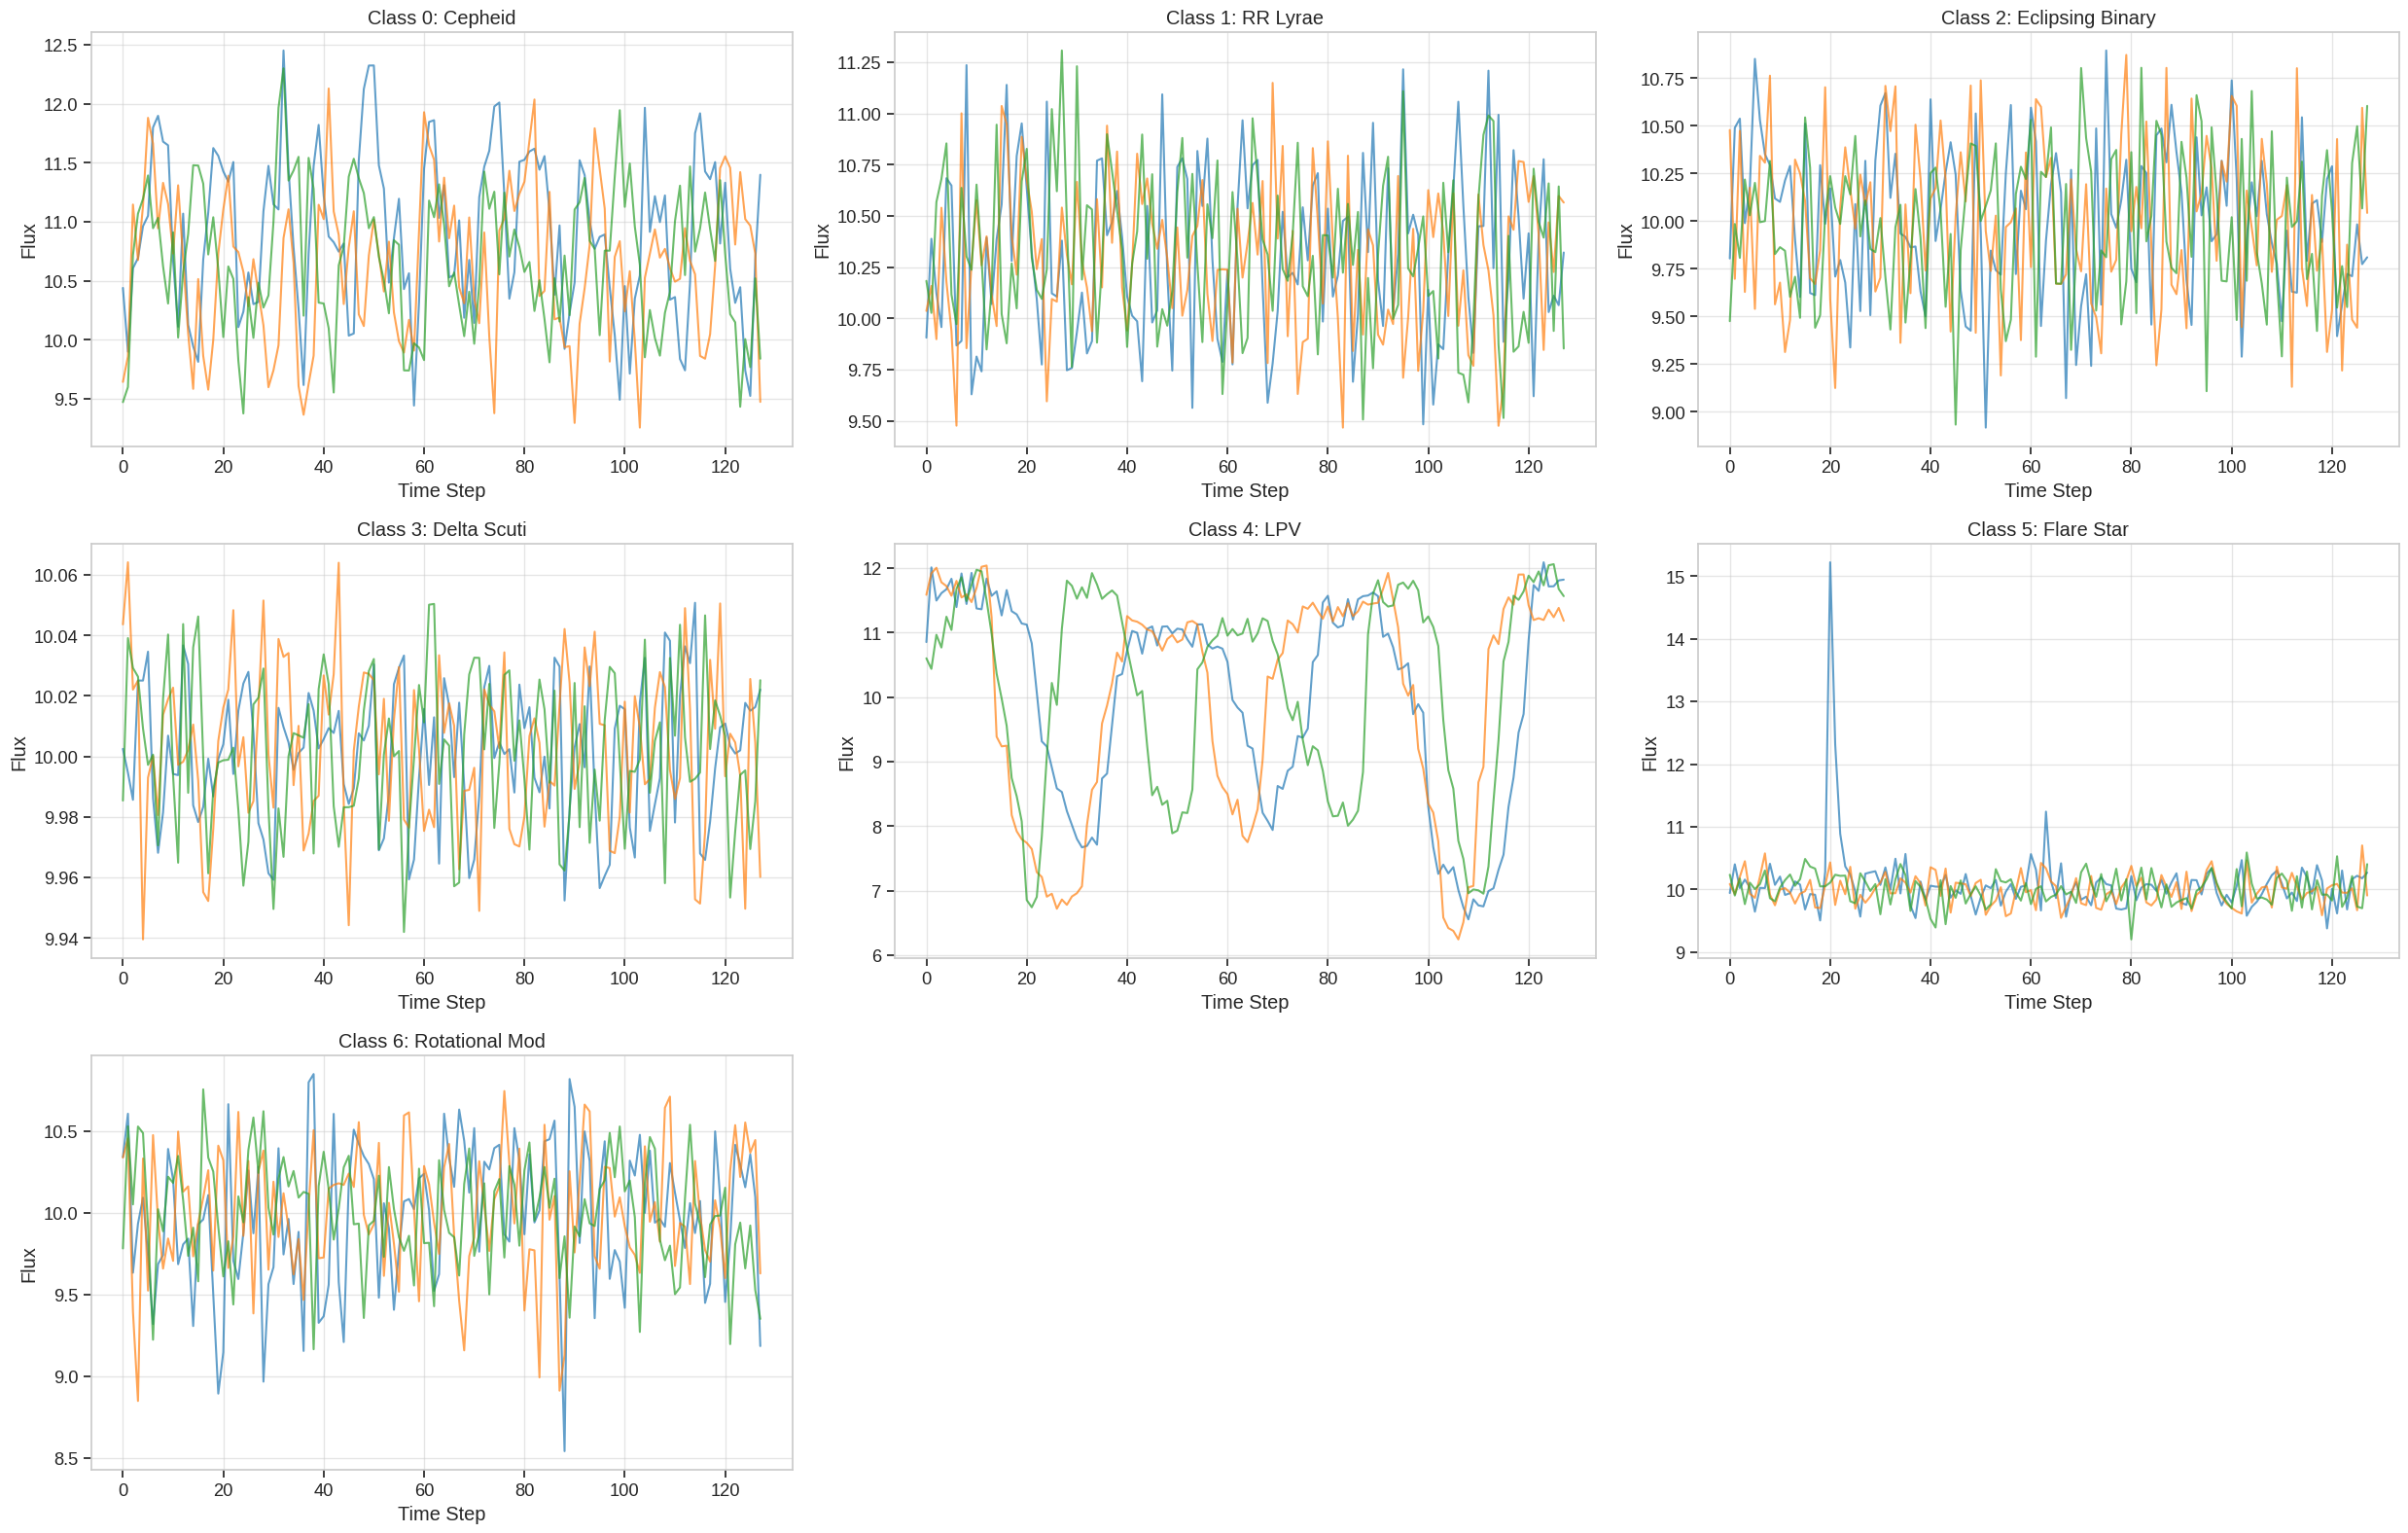

In [11]:
# --- Data Visualization ---
plt.figure(figsize=(25, 16))
time_axis = np.arange(TIME_SERIES_LENGTH)
n_random_sample = 3 # EDIT here to select the number of simultaneous sample plotted for each class

for i, class_name in enumerate(CLASS_NAMES):
    plt.subplot(3, 3, i + 1)
    idxs = np.random.choice(np.where(labels_data == i)[0], min(n_random_sample, len(np.where(labels_data == i)[0])), replace=False)  # Select n_random_sample random examples
    if len(idxs) > 0: # Check if examples exist for this class
        for idx in idxs:
            plt.plot(time_axis, series_data[idx], alpha=0.7)
        plt.title(f"Class {i}: {class_name}")
    else:
        plt.title(f"Class {i}: {class_name}\n(No samples found?)") # Handle case if a class wasn't generated properly
    plt.xlabel("Time Step")
    plt.ylabel("Flux")
    plt.grid(True, alpha=0.5)

plt.tight_layout()
plt.show()

In [12]:
# --- Train/Validation/Test Split ---
# Stage 1: Separate the test set (15% of total data).
# Stratify to maintain class proportions
X_train_val, X_test, y_train_val, y_test = train_test_split(
    series_data, labels_data, test_size=0.15, random_state=SEED, stratify=labels_data
)

# Stage 2: Split the remaining data (X_train_val, which is 85% of the original)
# into final training and validation sets.
# To make the validation set 15% of the *original* total, its size relative to
# X_train_val (which is 0.85 of total) must be 0.15 / 0.85.
X_train, X_val, y_train, y_val = train_test_split(
    X_train_val, y_train_val, test_size=0.15 / 0.85, random_state=SEED, stratify=y_train_val # ~15% of total for validation
)

print(f"Train set: {X_train.shape}, {y_train.shape}")
print(f"Validation set: {X_val.shape}, {y_val.shape}")
print(f"Test set: {X_test.shape}, {y_test.shape}")
print(f"Label distribution (Train): {np.bincount(y_train)}")
print(f"Label distribution (Validation): {np.bincount(y_val)}")
print(f"Label distribution (Test): {np.bincount(y_test)}")



Train set: (4900, 128), (4900,)
Validation set: (1050, 128), (1050,)
Test set: (1050, 128), (1050,)
Label distribution (Train): [700 700 700 700 700 700 700]
Label distribution (Validation): [150 150 150 150 150 150 150]
Label distribution (Test): [150 150 150 150 150 150 150]


In [13]:
# --- Preprocessing: Standardization ---
# Scaling is important for neural networks.
# Fit the scaler ONLY on the training data.
scaler = StandardScaler()

# Reshape for scaler: Needs 2D [n_samples * seq_len, 1] or [n_samples, seq_len]
# Let's scale each time series independently first, then maybe standardize across the dataset?
# Simpler approach: Treat each sample's sequence as features for the scaler.
# Fit on flattened training data
scaler.fit(X_train.reshape(-1, 1))

# Transform train, val, test
X_train_scaled = scaler.transform(X_train.reshape(-1, 1)).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)


# Add the feature dimension (required by PyTorch RNNs/CNNs: [batch, seq_len, features])
X_train_scaled = X_train_scaled[:, :, np.newaxis]
X_val_scaled = X_val_scaled[:, :, np.newaxis]
X_test_scaled = X_test_scaled[:, :, np.newaxis]

print(f"\nScaled train shape with feature dim: {X_train_scaled.shape}")
print(f"Mean after scaling (Train sample 0): {X_train_scaled[0].mean():.4f}") # Should be close to 0
print(f"Std after scaling (Train sample 0): {X_train_scaled[0].std():.4f}")   # Should be close to 1




Scaled train shape with feature dim: (4900, 128, 1)
Mean after scaling (Train sample 0): 0.6743
Std after scaling (Train sample 0): 0.7466


In [14]:
# --- PyTorch Dataset and DataLoader Creation ---

class TimeSeriesDataset(Dataset):
    """PyTorch Dataset for time series."""
    def __init__(self, series, labels, transform=None):
        # Ensure data is float32 for PyTorch tensors
        self.series = torch.tensor(series, dtype=torch.float32)
        # Ensure labels are long for CrossEntropyLoss
        self.labels = torch.tensor(labels, dtype=torch.long)
        self.transform = transform # Optional: for any further transformations

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        sample = self.series[idx]
        label = self.labels[idx]
        if self.transform:
            sample = self.transform(sample)
        # PyTorch RNNs expect [seq_len, features] or [batch, seq_len, features]
        # Our data is already [seq_len, features] per sample
        return sample, label

# Create Datasets
train_dataset = TimeSeriesDataset(X_train_scaled, y_train)
val_dataset = TimeSeriesDataset(X_val_scaled, y_val)
test_dataset = TimeSeriesDataset(X_test_scaled, y_test)

# Create DataLoaders
BATCH_SIZE = 64
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, pin_memory=True) # os.cpu_count() // 2, pin_memory=True)

# Verify a batch
try:
    data_iter = iter(train_loader)
    sample_batch, label_batch = next(data_iter)
    print(f"\nSample batch shape: {sample_batch.shape}") # [batch_size, seq_len, num_features]
    print(f"Label batch shape: {label_batch.shape}")
except Exception as e:
    print(f"\nError fetching batch, check DataLoader setup: {e}")




Sample batch shape: torch.Size([64, 128, 1])
Label batch shape: torch.Size([64])


Here we define the training functions

In [15]:
# --- Helper Functions for Training and Evaluation ---

def train_epoch(model, dataloader, criterion, optimizer, device, metrics_calculator):
    """Runs one training epoch."""
    model.train() # Set model to training mode
    metrics_calculator.reset()
    total_loss = 0.0

    for data, target in dataloader:
        data, target = data.to(device), target.to(device)

        # Zero gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(data)
        loss = criterion(output, target)

        # Backward pass and optimization
        loss.backward()
        optimizer.step()

        # Update metrics and loss
        total_loss += loss.item() * data.size(0) # Accumulate loss for the epoch
        # Detach output before passing to metrics to prevent gradient tracking issues
        metrics_calculator.update(output.detach(), target)

    avg_loss = total_loss / len(dataloader.dataset)
    metrics = metrics_calculator.compute()
    return avg_loss, metrics

def validate_epoch(model, dataloader, criterion, device, metrics_calculator):
    """Runs one validation epoch."""
    model.eval() # Set model to evaluation mode
    metrics_calculator.reset()
    total_loss = 0.0

    with torch.no_grad(): # Disable gradient calculation
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            metrics_calculator.update(output, target)

    avg_loss = total_loss / len(dataloader.dataset)
    metrics = metrics_calculator.compute()
    return avg_loss, metrics

def run_train(model, train_loader, val_loader, criterion, optimizer, device, num_epochs, model_name="best_model.pth", patience=5):
    """Main training loop with early stopping."""
    train_losses, val_losses = [], []
    train_accs, val_accs = [], []
    best_val_loss = float('inf')
    epochs_no_improve = 0

    # Initialize metrics calculators (per epoch)
    # Using Accuracy and F1-Score (macro average suitable for potentially imbalanced classes)
    metrics_train = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES),
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
    }).to(device)

    metrics_val = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=NUM_CLASSES),
        'f1': torchmetrics.F1Score(task="multiclass", num_classes=NUM_CLASSES, average='macro')
    }).to(device)


    for epoch in range(num_epochs):
        # Training
        train_loss, train_metrics = train_epoch(model, train_loader, criterion, optimizer, device, metrics_train)
        train_losses.append(train_loss)
        # Convert tensor metric to Python float
        train_acc = train_metrics['accuracy'].item()
        train_f1 = train_metrics['f1'].item()
        train_accs.append(train_acc)


        # Validation
        val_loss, val_metrics = validate_epoch(model, val_loader, criterion, device, metrics_val)
        val_losses.append(val_loss)
        val_acc = val_metrics['accuracy'].item()
        val_f1 = val_metrics['f1'].item()
        val_accs.append(val_acc)


        print(f"Epoch {epoch+1}/{num_epochs} | "
              f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f}, Train F1: {train_f1:.4f} | "
              f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}, Val F1: {val_f1:.4f}")

        # Early Stopping and Best Model Saving (based on validation loss)
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_name)
            print(f"   -> Validation loss decreased. Saved best model to {model_name}")
            epochs_no_improve = 0
        else:
            epochs_no_improve += 1
            print(f"   -> Validation loss did not improve for {epochs_no_improve} epoch(s).")

        if epochs_no_improve >= patience:
            print(f"\nEarly stopping triggered after {epoch + 1} epochs.")
            break

    history = {'train_loss': train_losses, 'val_loss': val_losses,
               'train_acc': train_accs, 'val_acc': val_accs}
    return history

def run_test(model, dataloader, criterion, device, class_names, model_path="best_model.pth"):
    """Evaluates the model on the test set."""
    try:
        # Load the best saved model
        model.load_state_dict(torch.load(model_path, map_location=device))
        model.eval()
    except FileNotFoundError:
        print(f"Error: Model file not found at {model_path}. Cannot evaluate.")
        return None
    except Exception as e:
        print(f"Error loading model state: {e}. Cannot evaluate.")
        return None


    # Metrics for the test set
    test_metrics = torchmetrics.MetricCollection({
        'accuracy': torchmetrics.Accuracy(task="multiclass", num_classes=len(class_names)).to(device),
        'f1_macro': torchmetrics.F1Score(task="multiclass", num_classes=len(class_names), average='macro').to(device),
        'f1_weighted': torchmetrics.F1Score(task="multiclass", num_classes=len(class_names), average='weighted').to(device),
        'conf_matrix': torchmetrics.ConfusionMatrix(task="multiclass", num_classes=len(class_names)).to(device)
    }).to(device)
    test_metrics.reset()

    total_loss = 0.0
    all_targets = []
    all_preds = []

    with torch.no_grad():
        for data, target in dataloader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            loss = criterion(output, target)

            total_loss += loss.item() * data.size(0)
            preds = torch.argmax(output, dim=1)
            test_metrics.update(preds, target) # Note: torchmetrics expects (preds, target)

            all_targets.extend(target.cpu().numpy())
            all_preds.extend(preds.cpu().numpy())


    avg_loss = total_loss / len(dataloader.dataset)
    final_metrics = test_metrics.compute()

    # Extract metrics safely, converting to CPU and Python float/numpy array
    accuracy = final_metrics['accuracy'].cpu().item()
    f1_macro = final_metrics['f1_macro'].cpu().item()
    f1_weighted = final_metrics['f1_weighted'].cpu().item()
    conf_matrix_tensor = final_metrics['conf_matrix'].cpu() # Keep as tensor for now
    conf_matrix_np = conf_matrix_tensor.numpy() # Convert to numpy for display

    print("\n--- Test Set Evaluation ---")
    print(f"Test Loss: {avg_loss:.4f}")
    print(f"Test Accuracy: {accuracy:.4f}")
    print(f"Test F1 Score (Macro): {f1_macro:.4f}")
    print(f"Test F1 Score (Weighted): {f1_weighted:.4f}")

    print("\nClassification Report:")
    # Ensure target_names matches the number of classes inferred from labels
    unique_labels = sorted(np.unique(all_targets))
    report_class_names = [class_names[i] for i in unique_labels]
    print(classification_report(all_targets, all_preds, target_names=report_class_names, digits=4))

    print("\nConfusion Matrix:")
    plt.figure(figsize=(len(class_names)*1.8, len(class_names)*1.5))
    sns.heatmap(conf_matrix_np, annot=True, fmt='d', cmap='Blues',
                xticklabels=report_class_names, yticklabels=report_class_names)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title("Confusion Matrix - Test Set")
    plt.show()

    # Return metrics including the confusion matrix tensor
    return {
        'loss': avg_loss,
        'accuracy': final_metrics['accuracy'], # Keep as tensor
        'f1_macro': final_metrics['f1_macro'], # Keep as tensor
        'f1_weighted': final_metrics['f1_weighted'], # Keep as tensor
        'conf_matrix': conf_matrix_tensor
    }

def draw_metric_hist(history, title='Model Training History'):
    """Draws learning curves."""
    if not history or 'train_loss' not in history or not history['train_loss']:
        print("History object is empty or missing data. Cannot plot.")
        return

    epochs = range(1, len(history['train_loss']) + 1)

    plt.figure(figsize=(12, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'bo-', label='Training Loss')
    if 'val_loss' in history and history['val_loss']:
      plt.plot(epochs, history['val_loss'], 'ro-', label='Validation Loss')
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'bo-', label='Training Accuracy')
    if 'val_acc' in history and history['val_acc']:
      plt.plot(epochs, history['val_acc'], 'ro-', label='Validation Accuracy')
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    plt.suptitle(title)
    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Adjust for global title
    plt.show()


## 3. LSTM classifier Model

In [16]:
class LSTMClassifier(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=1, num_classes=NUM_CLASSES, dropout_prob=0., bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1

        # Enhanced LSTM Layer
        self.lstm= nn.LSTM(input_size, hidden_size, num_layers,
                          batch_first=True,
                          dropout=dropout_prob if num_layers > 1 else 0,
                          bidirectional=bidirectional)

        # Example: Dropout layer after RNN
        self.dropout = nn.Dropout(dropout_prob)

        # Example: Linear layer (adjust input size based on bidirectionality)
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)

        # Select the output for the linear layer
        # Using the last time step's output is common and handles bidirectionality correctly here
        last_timestep_output = lstm_out[:, -1, :]

        # Apply dropout
        out = self.dropout(last_timestep_output)

        # Final classification layer
        out = self.fc(out)
        return out

 We define a very simple LSTM classifier:
 *   A single, unidirectional LSTM layer.
 *   A fully-connected linear layer for the final classification.
 *   No dropout

In [17]:
# --- Train Base LSTM ---

# Instantiate Model, Loss, Optimizer
lstm_base_model = LSTMClassifier(input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss() # Suitable for multi-class classification
optimizer_lstm_base = optim.Adam(lstm_base_model.parameters(), lr=0.0001)

print("--- Training Base LSTM Model ---")
# Reduce epochs for faster workshop execution, add patience for early stopping
NUM_EPOCHS = 15
PATIENCE = 3 # Stop after 3 epochs with no validation loss improvement

lstm_base_history = run_train(lstm_base_model, train_loader, val_loader, criterion, optimizer_lstm_base,
                              device, num_epochs=NUM_EPOCHS, model_name="lstm_base_best.pth", patience=PATIENCE)


--- Training Base LSTM Model ---
Epoch 1/15 | Train Loss: 1.9435, Train Acc: 0.1882, Train F1: 0.1076 | Val Loss: 1.9372, Val Acc: 0.1924, Val F1: 0.1148
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 2/15 | Train Loss: 1.9334, Train Acc: 0.1916, Train F1: 0.1143 | Val Loss: 1.9244, Val Acc: 0.2162, Val F1: 0.1373
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 3/15 | Train Loss: 1.9140, Train Acc: 0.2243, Train F1: 0.1408 | Val Loss: 1.8893, Val Acc: 0.3133, Val F1: 0.2374
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 4/15 | Train Loss: 1.7588, Train Acc: 0.3459, Train F1: 0.2502 | Val Loss: 1.6296, Val Acc: 0.3362, Val F1: 0.2220
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Epoch 5/15 | Train Loss: 1.5511, Train Acc: 0.3178, Train F1: 0.2271 | Val Loss: 1.4733, Val Acc: 0.3076, Val F1: 0.1902
   -> Validation loss decreased. Saved best model to lstm_base_best.pth
Ep

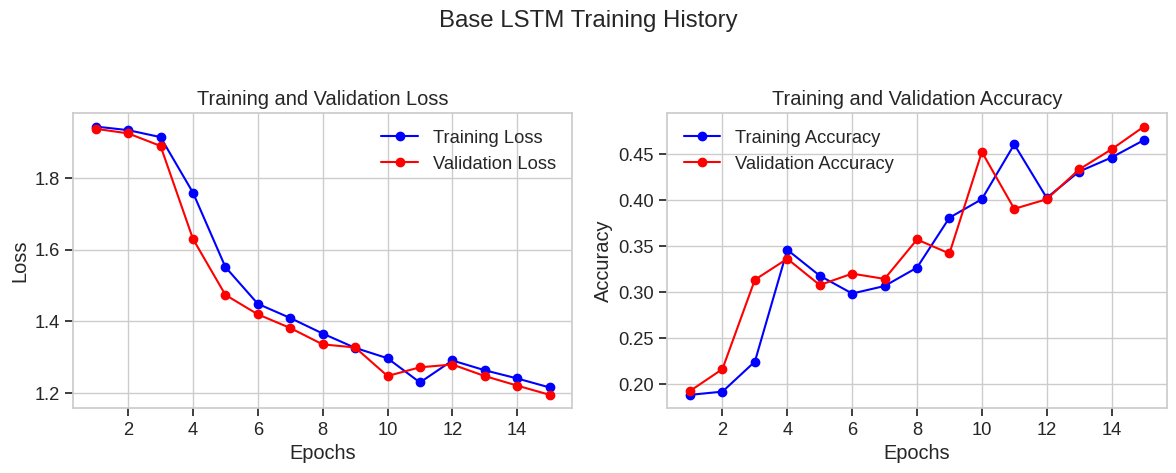

In [18]:
# --- Plot Base LSTM Learning Curves ---
draw_metric_hist(lstm_base_history, title='Base LSTM Training History')



--- Test Set Evaluation ---
Test Loss: 1.1983
Test Accuracy: 0.4886
Test F1 Score (Macro): 0.4148
Test F1 Score (Weighted): 0.4148

Classification Report:
                  precision    recall  f1-score   support

         Cepheid     0.6726    1.0000    0.8043       150
        RR Lyrae     0.8776    0.5733    0.6935       150
Eclipsing Binary     0.0000    0.0000    0.0000       150
     Delta Scuti     0.2712    1.0000    0.4267       150
             LPV     0.9590    0.7800    0.8603       150
      Flare Star     0.6000    0.0400    0.0750       150
  Rotational Mod     0.1176    0.0267    0.0435       150

        accuracy                         0.4886      1050
       macro avg     0.4997    0.4886    0.4148      1050
    weighted avg     0.4997    0.4886    0.4148      1050


Confusion Matrix:


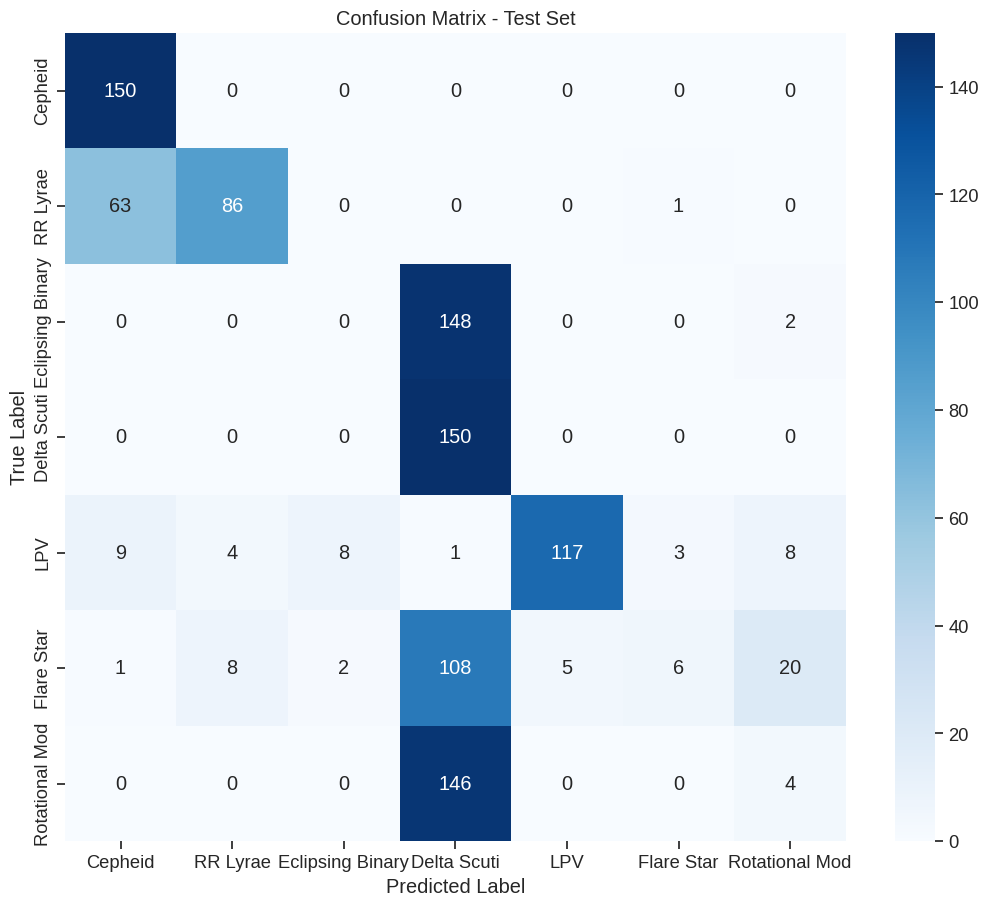

In [19]:
# --- Evaluate Base LSTM on Test Set ---
lstm_base_test_metrics = run_test(lstm_base_model, test_loader, criterion, device,
                                  class_names=CLASS_NAMES, model_path="lstm_base_best.pth")


 **Base LSTM Comments:** Observe the metrics (accuracy, F1, confusion matrix). The model likely learned something, but there might be significant errors, especially between classes with subtle differences or requiring understanding of longer-term patterns or specific event shapes (like eclipses). This indicates room for improvement.

 ## 4. GRU classification model

In [20]:
class GRUClassifier(nn.Module):
    """Enhanced GRU Classifier for the Solution."""
    def __init__(self, input_size=1, hidden_size=128, num_layers=1, num_classes=NUM_CLASSES, dropout_prob=0., bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bidirectional = bidirectional
        num_directions = 2 if bidirectional else 1

        self.gru = nn.GRU(input_size, hidden_size, num_layers,
                            batch_first=True,
                            dropout=dropout_prob if num_layers > 1 else 0, # Only apply RNN dropout if layers > 1
                            bidirectional=bidirectional)

        # Dropout layer after GRU
        self.dropout = nn.Dropout(dropout_prob)

        # Adjust linear layer input size
        self.fc = nn.Linear(hidden_size * num_directions, num_classes)

    def forward(self, x):
        gru_out, _ = self.gru(x) # We only need the output sequence here

        # Get the output of the last time step (handles bidirectionality)
        last_timestep_output = gru_out[:, -1, :]

        # Apply dropout before the final layer
        out = self.dropout(last_timestep_output)

        # Final linear layer
        out = self.fc(out)
        return out

Now, let's implement a base GRU model, structurally similar to the base LSTM (single layer, unidirectional), to see if GRU performs differently on this task.

In [21]:
# --- Train Base GRU ---
gru_base_model = GRUClassifier(input_size=1, hidden_size=64, num_layers=1, num_classes=NUM_CLASSES).to(device)
criterion = nn.CrossEntropyLoss() # Reuse the same loss function
optimizer_gru_base = optim.Adam(gru_base_model.parameters(), lr=0.0001)

print("\n--- Training Base GRU Model ---")
gru_base_history = run_train(gru_base_model, train_loader, val_loader, criterion, optimizer_gru_base,
                             device, num_epochs=NUM_EPOCHS, model_name="gru_base_best.pth", patience=PATIENCE)



--- Training Base GRU Model ---
Epoch 1/15 | Train Loss: 1.9503, Train Acc: 0.1092, Train F1: 0.0581 | Val Loss: 1.9421, Val Acc: 0.1410, Val F1: 0.0411
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 2/15 | Train Loss: 1.9356, Train Acc: 0.1620, Train F1: 0.0698 | Val Loss: 1.9273, Val Acc: 0.1790, Val F1: 0.0873
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 3/15 | Train Loss: 1.9170, Train Acc: 0.2108, Train F1: 0.1081 | Val Loss: 1.9028, Val Acc: 0.2238, Val F1: 0.1116
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 4/15 | Train Loss: 1.8541, Train Acc: 0.2653, Train F1: 0.1368 | Val Loss: 1.7096, Val Acc: 0.2952, Val F1: 0.1574
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 5/15 | Train Loss: 1.5832, Train Acc: 0.3000, Train F1: 0.1602 | Val Loss: 1.4834, Val Acc: 0.3086, Val F1: 0.1740
   -> Validation loss decreased. Saved best model to gru_base_best.pth
Epoch 6

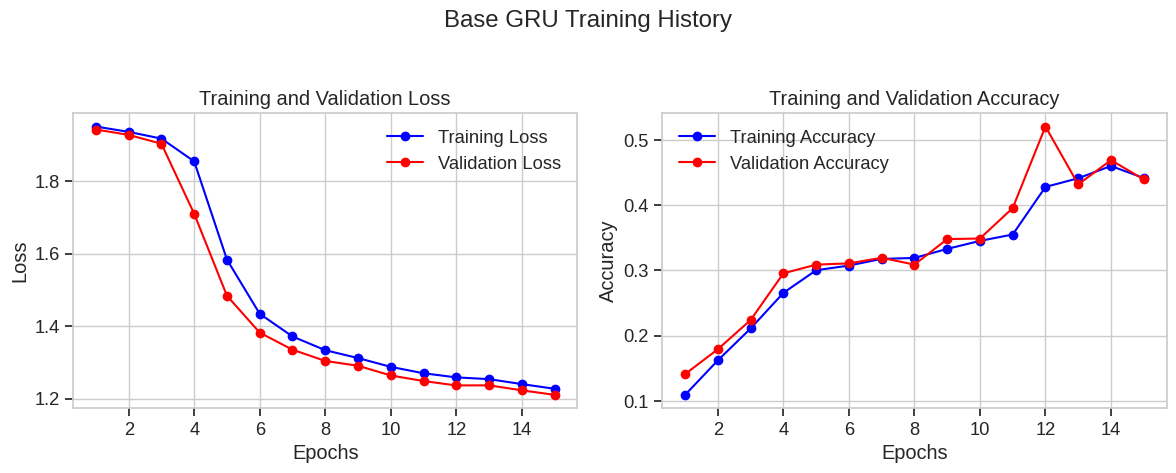

In [22]:
# --- Plot Base GRU Learning Curves ---
draw_metric_hist(gru_base_history, title='Base GRU Training History')



--- Test Set Evaluation ---
Test Loss: 1.2240
Test Accuracy: 0.4467
Test F1 Score (Macro): 0.3837
Test F1 Score (Weighted): 0.3837

Classification Report:
                  precision    recall  f1-score   support

         Cepheid     0.5929    1.0000    0.7444       150
        RR Lyrae     0.8487    0.8600    0.8543       150
Eclipsing Binary     0.2527    0.7867    0.3825       150
     Delta Scuti     0.0000    0.0000    0.0000       150
             LPV     0.9688    0.4133    0.5794       150
      Flare Star     1.0000    0.0667    0.1250       150
  Rotational Mod     0.0000    0.0000    0.0000       150

        accuracy                         0.4467      1050
       macro avg     0.5233    0.4467    0.3837      1050
    weighted avg     0.5233    0.4467    0.3837      1050


Confusion Matrix:


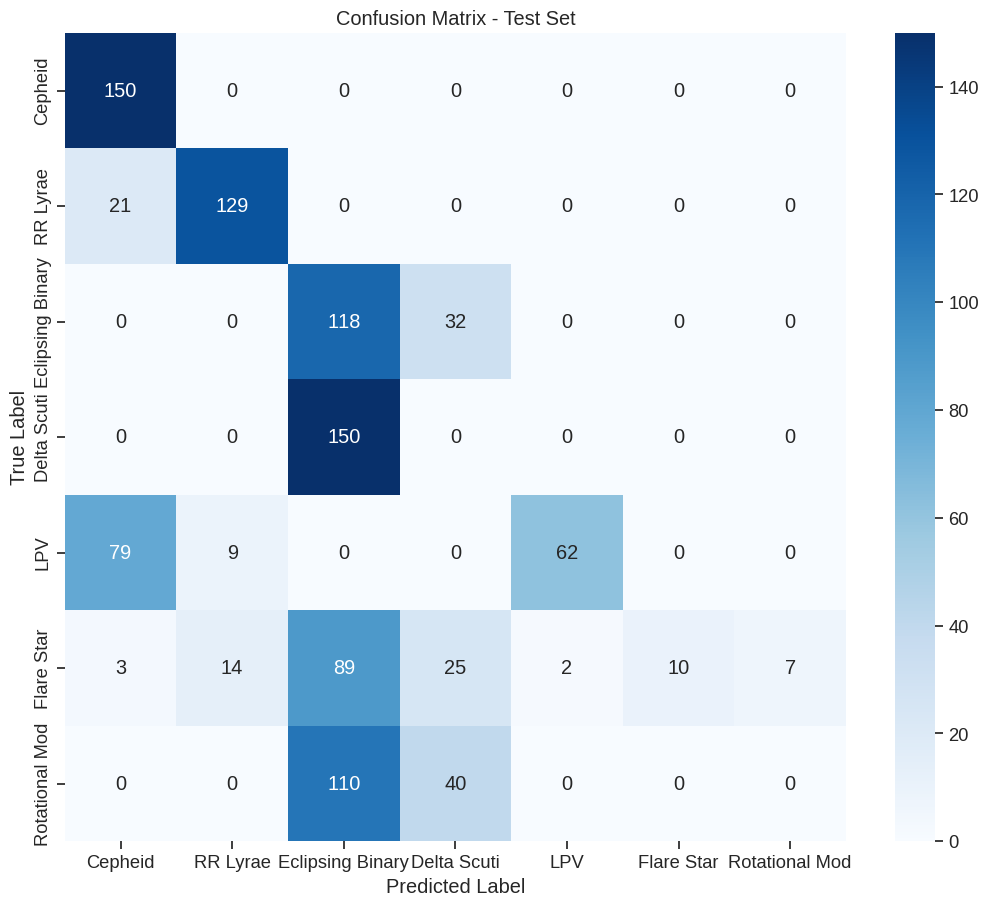

In [23]:
# --- Evaluate Base GRU on Test Set ---
gru_base_test_metrics = run_test(gru_base_model, test_loader, criterion, device,
                                 class_names=CLASS_NAMES, model_path="gru_base_best.pth")


 ## 5. Exercise: Enhance RNN Architectures



 **Your Task:** Now it's time to enhance the RNN models! The base models are intentionally simple (unidirectional, 1 layer). This limits their ability to:

 *   Capture hierarchical temporal dependencies (addressable with `num_layers > 1`).

 *   Use information from both past and future context at a given time step (addressable with `bidirectional=True`).

 *   Manage overfitting in more complex models (mitigated with `dropout`).



 **Goal:** Instantiate different `LSTMClassifier` or `GRUClassifier` models to include **at least one** of the following techniques:



 1.  **Multiple Layers:** Set `num_layers` to 2 or more in the `nn.LSTM` or `nn.GRU` initialization.

     *   *Note:* The hidden state output `h_n` will have shape `[num_layers * num_directions, batch, hidden_size]`. To use only the last state of the *last layer*, you need to select it correctly (e.g., `h_n[-1]` if unidirectional, or combine `h_n[-1]` and `h_n[-2]` if bidirectional and taking the last layer's forward and backward states).

 2.  **Bidirectionality:** Set `bidirectional=True`.

     *   *Important:* The RNN output (e.g., `gru_out`) will now have shape `[batch, seq_len, hidden_size * 2]`.

     *   *Important:* The hidden state `h_n` will have shape `[num_layers * 2, batch, hidden_size]`.

     *   *Important:* The subsequent linear layer (`nn.Linear`) **must** now accept an input dimension of `hidden_size * 2` if you use the concatenated hidden states (e.g., `torch.cat((h_n[-2,:,:], h_n[-1,:,:]), dim=1)`) or the output of the last time step (`lstm_out[:, -1, :]`). Using `lstm_out[:, -1, :]` is often simplest with `batch_first=True`.

 3.  **Dropout:**

     *   Add the `dropout=dropout_prob` argument (with `dropout_prob > 0`, e.g., 0.2-0.5) to `nn.LSTM` or `nn.GRU`. This applies dropout *between* RNN layers (so it only has an effect if `num_layers > 1`).

     *   Add `nn.Dropout(p=dropout_prob)` layers *after* the RNN layer and/or *before* the final linear layer to regularize the output features.



 **Tips:**

 *   Start by modifying just one aspect (e.g., add `bidirectional=True`) and observe the impact.

 *   Try combining techniques (e.g., `num_layers=2`, `bidirectional=True`, `dropout=0.3`).

 *   You might need to adjust `hidden_size` or the optimizer's learning rate (`lr`).

 **Write your code in the cells below.**

In [ ]:
# ##### ADD YOUR CODE HERE ######